<center><img src="https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/Flower%20Classification%20with%20TPUs/banner.png" width="1000"></center>
<br>
<center><h1>Flower with TPUs - K-Fold optimized training loops</h1></center>
<br>

#### This notebooks implements Martin Gorner's suggestions to improve training time, here I'll also show how to incorporate the optimizations inside a tipical K-Fold training loop. From the [reference notebook](https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu):

#### Optimizations:
- use dataset.batch(BATCH_SIZE, drop_remainder=True)
The training dataset is infinitely repeated so drop_remainder=True should not be needed. However, whith the setting, Tensorflow produces batches of a known size and although XLA (the TPU compiler) can now handle variable batches, it is slightly faster on fixed batches.
On the validation dataset, this setting can drop some validation images. It is not the case here because the validation dataset happens to contain an integral number of batches.

#### Optimizations specific to the TPU-optimized custom training loop:
- The training and validation step functions run multiple batches at once. This is achieved by placing a loop using `tf.range()` in the step function. The loop will be compiled to (thanks to ` @tf.function`) and executed on TPU.
- The validation dataset is made to repeat indefinitely because handling end-of-dataset exception in a TPU loop implemented with `tf.range()` is not yet possible. Validation is adjusted to always use exactly or more than the entire validation dataset. This could change numerics. It happens that in this example, the validation dataset is used exactly once per validation.
- The validation dataset iterator is not reset between validation runs. Since the iterator is passed into the step function which is then compiled for TPU (thanks to ` @tf.function`), passing a fresh iterator for every validation run would trigger a fresh recompilation. With a validation at the end of every epoch this would be slow.
- Losses are reported through Keras metrics. It is possible to return values from step function and return losses in that way. However, in the optimized version of the custom training loop, using `tf.range()`, aggregating losses returned from multiple batches becomes impractical.

## Dependencies

In [1]:
!pip install --quiet efficientnet

import numpy as np
import pandas as pd
import seaborn as sns
import os, re, math, warnings, time
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers, applications, Sequential, layers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import efficientnet.tfkeras as efn

def seed_everything(seed=0):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

### TPU configuration

In [2]:
# TPU or GPU detection
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


# Model parameters

In [3]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
EPOCHS = 10
LEARNING_RATE = 3e-5 * strategy.num_replicas_in_sync
HEIGHT = 512
WIDTH = 512
CHANNELS = 3
N_CLASSES = 104
N_FOLDS = 5
FOLDS_USED = 3

GCS_PATH = KaggleDatasets().get_gcs_path() + '/tfrecords-jpeg-%sx%s' % (HEIGHT, WIDTH)

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec') + tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec')

CLASSES = [
    'pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', 
    'wild geranium', 'tiger lily', 'moon orchid', 'bird of paradise', 'monkshood', 
    'globe thistle', 'snapdragon', "colt's foot", 'king protea', 'spear thistle', 
    'yellow iris', 'globe-flower', 'purple coneflower', 'peruvian lily', 
    'balloon flower', 'giant white arum lily', 'fire lily', 'pincushion flower', 
    'fritillary', 'red ginger', 'grape hyacinth', 'corn poppy', 
    'prince of wales feathers', 'stemless gentian', 'artichoke', 'sweet william', 
    'carnation', 'garden phlox', 'love in the mist', 'cosmos',  'alpine sea holly', 
    'ruby-lipped cattleya', 'cape flower', 'great masterwort',  'siam tulip', 
    'lenten rose', 'barberton daisy', 'daffodil',  'sword lily', 'poinsettia', 
    'bolero deep blue',  'wallflower', 'marigold', 'buttercup', 'daisy', 
    'common dandelion', 'petunia', 'wild pansy', 'primula',  'sunflower', 
    'lilac hibiscus', 'bishop of llandaff', 'gaura',  'geranium', 'orange dahlia', 
    'pink-yellow dahlia', 'cautleya spicata',  'japanese anemone', 'black-eyed susan', 
    'silverbush', 'californian poppy',  'osteospermum', 'spring crocus', 'iris', 
    'windflower',  'tree poppy', 'gazania', 'azalea', 'water lily',  'rose', 
    'thorn apple', 'morning glory', 'passion flower',  'lotus', 'toad lily', 
    'anthurium', 'frangipani',  'clematis', 'hibiscus', 'columbine', 'desert-rose', 
    'tree mallow', 'magnolia', 'cyclamen ', 'watercress',  'canna lily', 
    'hippeastrum ', 'bee balm', 'pink quill',  'foxglove', 'bougainvillea', 
    'camellia', 'mallow',  'mexican petunia',  'bromelia', 'blanket flower', 
    'trumpet creeper',  'blackberry lily', 'common tulip', 'wild rose']

In [4]:
# Datasets utility functions
AUTO = tf.data.experimental.AUTOTUNE # instructs the API to read from multiple files if available.

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [HEIGHT, WIDTH, 3])
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=seed)
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=seed)
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=seed)
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32', seed=seed)
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image = tf.image.random_flip_left_right(image, seed=seed)
        image = tf.image.random_flip_up_down(image, seed=seed)
        
    if p_crop >= .7: # crops
        if p_crop >= .95:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.6), int(WIDTH*.6), CHANNELS], seed=seed)
        elif p_crop >= .85:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.7), int(WIDTH*.7), CHANNELS], seed=seed)
        elif p_crop >= .8:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.8), int(WIDTH*.8), CHANNELS], seed=seed)
        else:
            image = tf.image.random_crop(image, size=[int(HEIGHT*.9), int(WIDTH*.9), CHANNELS], seed=seed)
        image = tf.image.resize(image, size=[HEIGHT, WIDTH])
    
    ## Pixel-level transforms
    if p_pixel >= .4: # pixel transformations
        if p_pixel >= .85:
            image = tf.image.random_saturation(image, lower=0, upper=2, seed=seed)
        elif p_pixel >= .65:
            image = tf.image.random_contrast(image, lower=.8, upper=2, seed=seed)
        elif p_pixel >= .5:
            image = tf.image.random_brightness(image, max_delta=.2, seed=seed)
        else:
            image = tf.image.adjust_gamma(image, gamma=.6)

    return image, label

def get_training_dataset(filenames):
    dataset = load_dataset(filenames, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False):
    dataset = load_dataset(filenames, labeled=True, ordered=ordered)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
#     dataset = dataset.batch(BATCH_SIZE, drop_remainder=repeated)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO)
    return dataset

def get_test_dataset(filenames=TEST_FILENAMES, ordered=True):
    dataset = load_dataset(filenames, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def int_div_round_up(a, b):
    return (a + b - 1) // b

In [5]:
# Visualization utility functions
np.set_printoptions(threshold=15, linewidth=80)

def plot_metrics(history, metric_list):
    fig, axes = plt.subplots(len(metric_list), 1, sharex='col', figsize=(24, 12))
    axes = axes.flatten()
    
    for index, metric in enumerate(metric_list):
        axes[index].plot(history[metric], label='Train %s' % metric)
        axes[index].plot(history['val_%s' % metric], label='Validation %s' % metric)
        axes[index].legend(loc='best', fontsize=16)
        axes[index].set_title(metric)

    plt.xlabel('Epochs', fontsize=16)
    sns.despine()
    plt.show()

    
def dataset_to_numpy_util(dataset, N):
    dataset = dataset.unbatch().batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;  
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    label = np.argmax(label, axis=-1)
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower_eval(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=14, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(predictions[i], labels[i])
        subplot = display_one_flower_eval(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

## About the datasets

In [6]:
# Train data
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
train_dataset = get_training_dataset(TRAINING_FILENAMES)
y_train = next(iter(train_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print('Number of training images %d' % NUM_TRAINING_IMAGES)

# Test data
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
print('Number of test images %d' % NUM_TEST_IMAGES)
test_dataset = get_test_dataset(ordered=True)

Number of training images 16465
Number of test images 7382


# Model

In [7]:
def create_model(input_shape, N_CLASSES):
    base_model = efn.EfficientNetB0(weights='noisy-student', 
                                    include_top=False,
                                    input_shape=input_shape)

    model = tf.keras.Sequential([
            base_model,
            layers.GlobalAveragePooling2D(),
            layers.Dense(N_CLASSES, activation='softmax')
            ])
    
    return model

## Learning rate schedule

Learning rate schedule: 1e-08 to 0.00024 to 6.37e-05


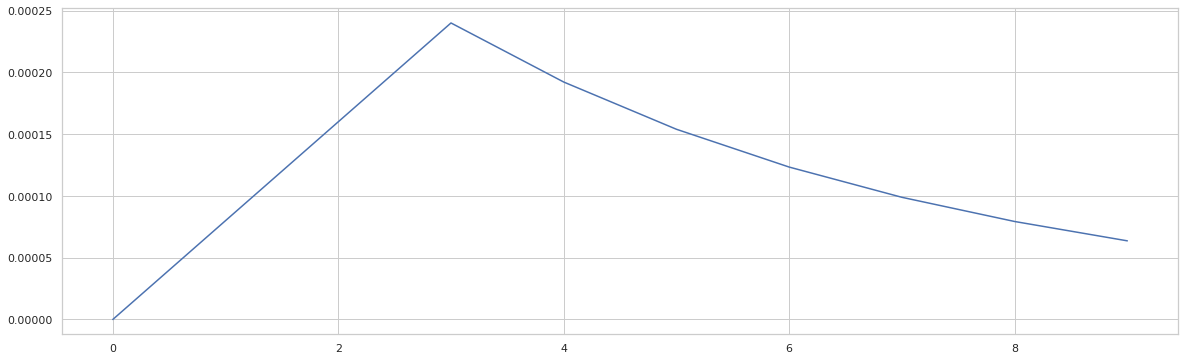

In [8]:
LR_START = 0.00000001
LR_MIN = 0.000001
LR_MAX = LEARNING_RATE
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Optimized training loop

In [9]:
history_list = []
model_path_list = []
kfold = KFold(N_FOLDS, shuffle=True, random_state=seed)
for n_fold, (trn_ind, val_ind) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < FOLDS_USED:
        tf.tpu.experimental.initialize_tpu_system(tpu) # clear TPU memory
        print(f'##### FOLD {n_fold} #####')    
        ### Data
        fold_train_filenames = np.asarray(TRAINING_FILENAMES)[trn_ind]
        fold_valid_filenames = np.asarray(TRAINING_FILENAMES)[val_ind]
        train_size = count_data_items(fold_train_filenames)
        validation_size = count_data_items(fold_valid_filenames)
        
        # distribute the datset according to the strategy
        train_dist_ds = strategy.experimental_distribute_dataset(get_training_dataset(fold_train_filenames))
        # Hitting End Of Dataset exceptions is a problem in this setup. Using a repeated validation set instead.
        # This will introduce a slight inaccuracy because the validation dataset now has some repeated elements.
        valid_dist_ds = strategy.experimental_distribute_dataset(get_validation_dataset(fold_valid_filenames, repeated=True))
        
        train_data_iter = iter(train_dist_ds) # the training data iterator is repeated and it is not reset
                                              # for each validation run (same as model.fit)
        valid_data_iter = iter(valid_dist_ds) # the validation data iterator is repeated and it is not reset
                                              # for each validation run (different from model.fit whre the  
                                              # recommendation is to use a non-repeating validation dataset)
                                              # recommendation is to use a non-repeating validation dataset)

        STEPS_PER_TPU_CALL = STEPS_PER_EPOCH = train_size//BATCH_SIZE
        VALIDATION_STEPS_PER_TPU_CALL = validation_size//BATCH_SIZE
        
        # Step functions (must be called everytime for each fold)
        @tf.function
        def train_step(data_iter):
            def train_step_fn(images, labels):
                with tf.GradientTape() as tape:
                    probabilities = model(images, training=True)
                    loss = loss_fn(labels, probabilities)
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))
                train_accuracy.update_state(labels, probabilities)
                train_loss.update_state(loss)
            for _ in tf.range(STEPS_PER_TPU_CALL):
                strategy.experimental_run_v2(train_step_fn, next(data_iter))

        @tf.function
        def valid_step(data_iter):
            def valid_step_fn(images, labels):
                probabilities = model(images, training=False)
                loss = loss_fn(labels, probabilities)
                valid_accuracy.update_state(labels, probabilities)
                valid_loss.update_state(loss)
            for _ in tf.range(VALIDATION_STEPS_PER_TPU_CALL):
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))
        
        ### Model
        model_path = 'model_%sx%s_fold_%d.h5' % (HEIGHT, WIDTH, (n_fold+1))
        with strategy.scope():
            model = create_model((None, None, CHANNELS), N_CLASSES)
            
            # Instiate optimizer with learning rate schedule
            class LRSchedule(optimizers.schedules.LearningRateSchedule):
                def __call__(self, step):
                    return lrfn(epoch=step//STEPS_PER_EPOCH)
            optimizer = optimizers.Adam(learning_rate=LRSchedule())
            
            train_accuracy = metrics.SparseCategoricalAccuracy()
            valid_accuracy = metrics.SparseCategoricalAccuracy()
            train_loss = metrics.Sum()
            valid_loss = metrics.Sum()

            loss_fn = losses.sparse_categorical_crossentropy

        step = 0
        epoch = 0
        epoch_steps = 0
        epoch_start_time = time.time()
        history = {'loss': [], 'val_loss': [], 'sparse_categorical_accuracy': [], 'val_sparse_categorical_accuracy': []}
        
        ### Train model
        while True:
            # run training step
            train_step(train_data_iter)
            epoch_steps += STEPS_PER_TPU_CALL
            step += STEPS_PER_TPU_CALL

            # validation run at the end of each epoch
            if (step // STEPS_PER_EPOCH) > epoch:
                # validation run
                valid_epoch_steps = 0
                for _ in range(int_div_round_up(validation_size, BATCH_SIZE*VALIDATION_STEPS_PER_TPU_CALL)):
                    valid_step(valid_data_iter)
                    valid_epoch_steps += VALIDATION_STEPS_PER_TPU_CALL

                # compute metrics
                history['sparse_categorical_accuracy'].append(train_accuracy.result().numpy())
                history['val_sparse_categorical_accuracy'].append(valid_accuracy.result().numpy())
                history['loss'].append(train_loss.result().numpy() / (BATCH_SIZE*epoch_steps))
                history['val_loss'].append(valid_loss.result().numpy() / (BATCH_SIZE*valid_epoch_steps))

                # report metrics
                epoch_time = time.time() - epoch_start_time
                print('\nEPOCH {:d}/{:d}'.format(epoch+1, EPOCHS))
                print('time: {:0.1f}s'.format(epoch_time),
                      'loss: {:0.4f}'.format(history['loss'][-1]),
                      'sparse_categorical_accuracy: {:0.4f}'.format(history['sparse_categorical_accuracy'][-1]),
                      'val_loss: {:0.4f}'.format(history['val_loss'][-1]),
                      'val_sparse_categorical_accuracy: {:0.4f}'.format(history['val_sparse_categorical_accuracy'][-1]))
                print('LearningRate: {:0.4g}'.format(lrfn(epoch)))

                # set up next epoch
                epoch = step // STEPS_PER_EPOCH
                epoch_steps = 0
                epoch_start_time = time.time()
                train_accuracy.reset_states()
                valid_accuracy.reset_states()
                valid_loss.reset_states()
                train_loss.reset_states()
                if epoch >= EPOCHS:
                    break
                    
        history_list.append(history)
        model_path_list.append(model_path)
        model.save(model_path)

##### FOLD 0 #####
16703488/16696600 [==============================] - 0s 0us/step

EPOCH 1/10
time: 130.3s loss: 4.6713 sparse_categorical_accuracy: 0.0073 val_loss: 4.6823 val_sparse_categorical_accuracy: 0.0173
LearningRate: 1e-08

EPOCH 2/10
time: 33.4s loss: 3.8950 sparse_categorical_accuracy: 0.2095 val_loss: 2.9893 val_sparse_categorical_accuracy: 0.3730
LearningRate: 8.001e-05

EPOCH 3/10
time: 32.3s loss: 2.0717 sparse_categorical_accuracy: 0.5409 val_loss: 2.2277 val_sparse_categorical_accuracy: 0.5904
LearningRate: 0.00016

EPOCH 4/10
time: 30.2s loss: 1.0251 sparse_categorical_accuracy: 0.7592 val_loss: 0.7694 val_sparse_categorical_accuracy: 0.8227
LearningRate: 0.00024

EPOCH 5/10
time: 27.1s loss: 0.6431 sparse_categorical_accuracy: 0.8491 val_loss: 0.3913 val_sparse_categorical_accuracy: 0.9107
LearningRate: 0.0001922

EPOCH 6/10
time: 23.5s loss: 0.4858 sparse_categorical_accuracy: 0.8859 val_loss: 0.3326 val_sparse_categorical_accuracy: 0.9180
LearningRate: 0.000154


## Model loss graph

##### FOLD 0 #####


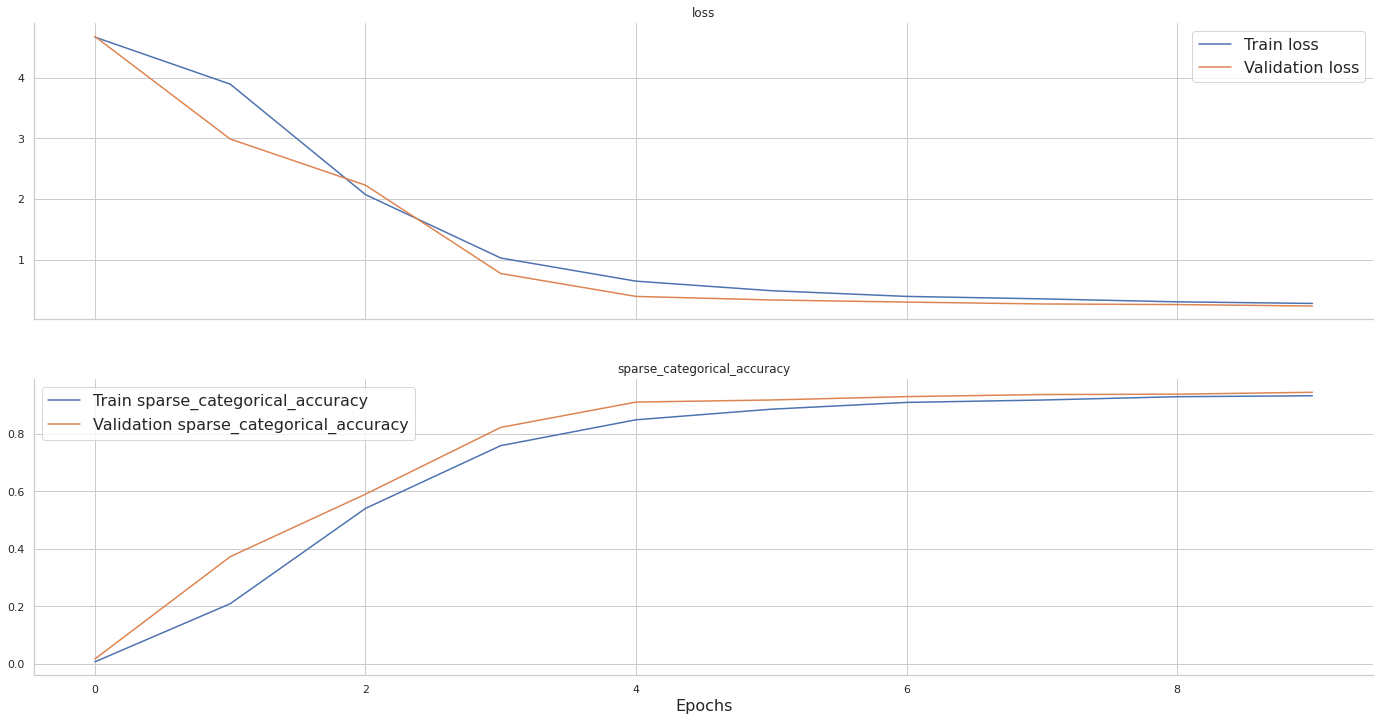

##### FOLD 1 #####


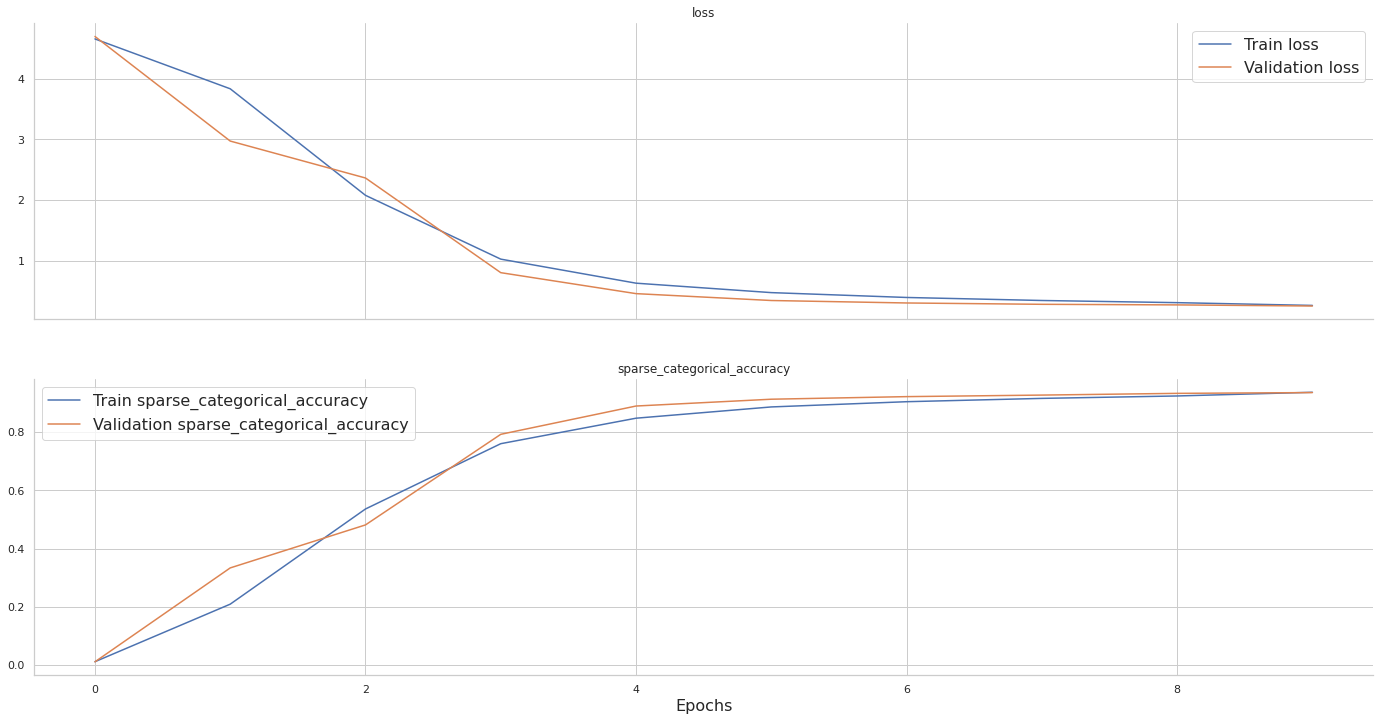

##### FOLD 2 #####


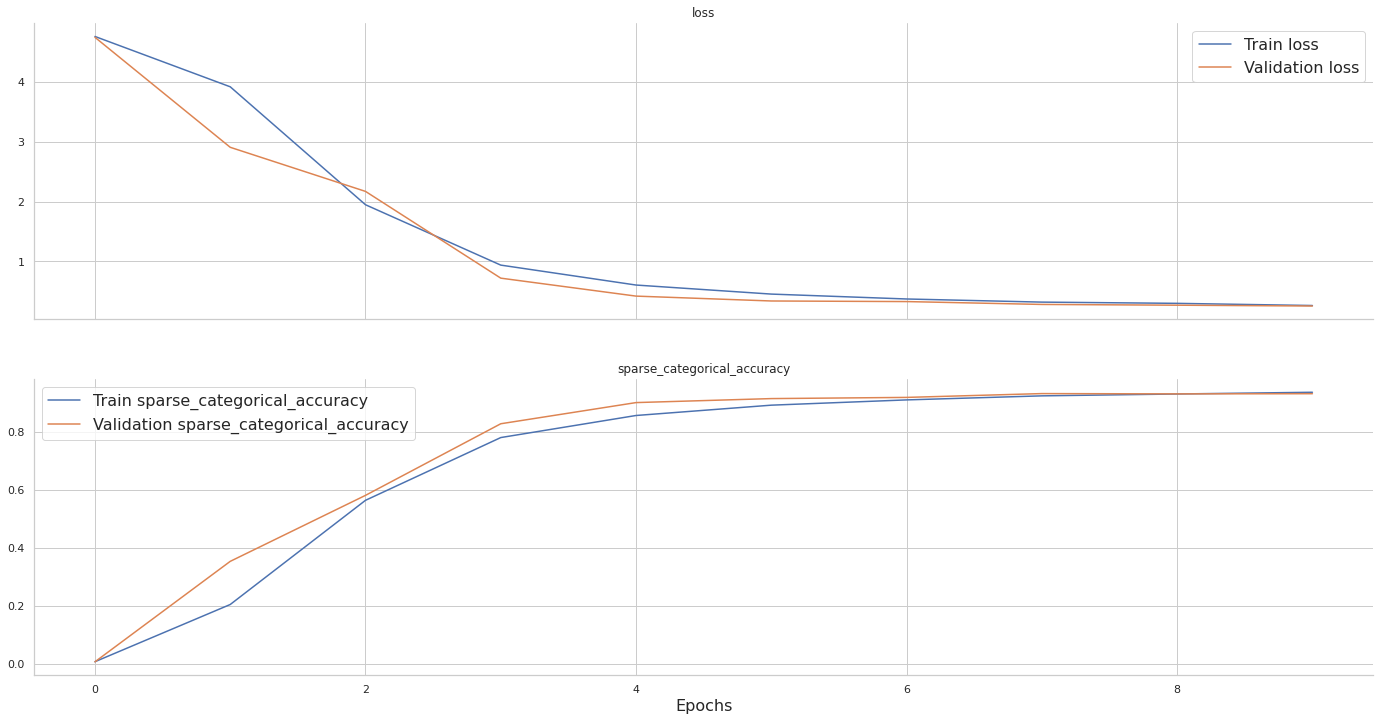

In [10]:
sns.set(style="whitegrid")
for index, history in enumerate(history_list):
    print(f'##### FOLD {index} #####')
    plot_metrics(history, metric_list=['loss', 'sparse_categorical_accuracy'])

# Make predictions

In [11]:
# Train predictions
complete_dataset = get_validation_dataset(TRAINING_FILENAMES, ordered=True)
x_complete = complete_dataset.map(lambda image, label: image)
complete_preds = np.zeros((NUM_TRAINING_IMAGES, N_CLASSES))
# Test predictions
x_test = test_dataset.map(lambda image, idnum: image)
test_preds = np.zeros((NUM_TEST_IMAGES, N_CLASSES))

for model_path in model_path_list:
    print(model_path)
    ### Model
    with strategy.scope():
        model = load_model(model_path)
                    
    complete_preds += model.predict(x_complete) / FOLDS_USED
    test_preds += model.predict(x_test) / FOLDS_USED
    
complete_preds = np.argmax(complete_preds, axis=-1)
test_preds = np.argmax(test_preds, axis=-1)

model_512x512_fold_1.h5
model_512x512_fold_2.h5
model_512x512_fold_3.h5


# Model evaluation

In [12]:
y_complete = next(iter(complete_dataset.unbatch().map(lambda image, label: label).batch(NUM_TRAINING_IMAGES))).numpy()
print(classification_report(y_complete, complete_preds, target_names=CLASSES))

                           precision    recall  f1-score   support

            pink primrose       1.00      1.00      1.00       351
hard-leaved pocket orchid       1.00      1.00      1.00        33
         canterbury bells       1.00      0.81      0.89        26
                sweet pea       1.00      0.56      0.71        27
            wild geranium       0.99      1.00      1.00       908
               tiger lily       1.00      0.93      0.96       112
              moon orchid       0.96      1.00      0.98        23
         bird of paradise       0.99      0.99      0.99       136
                monkshood       0.96      0.96      0.96       112
            globe thistle       0.98      0.99      0.99       108
               snapdragon       0.97      0.97      0.97       176
              colt's foot       0.98      0.98      0.98        56
              king protea       0.97      0.97      0.97       119
            spear thistle       0.97      0.99      0.98     

# Confusion matrix

I have split confusion matrices into 3 parts to make it clearer, the first plot has classes 1 from 34, the second plot 35 to 69 and the third has the remaining ones.

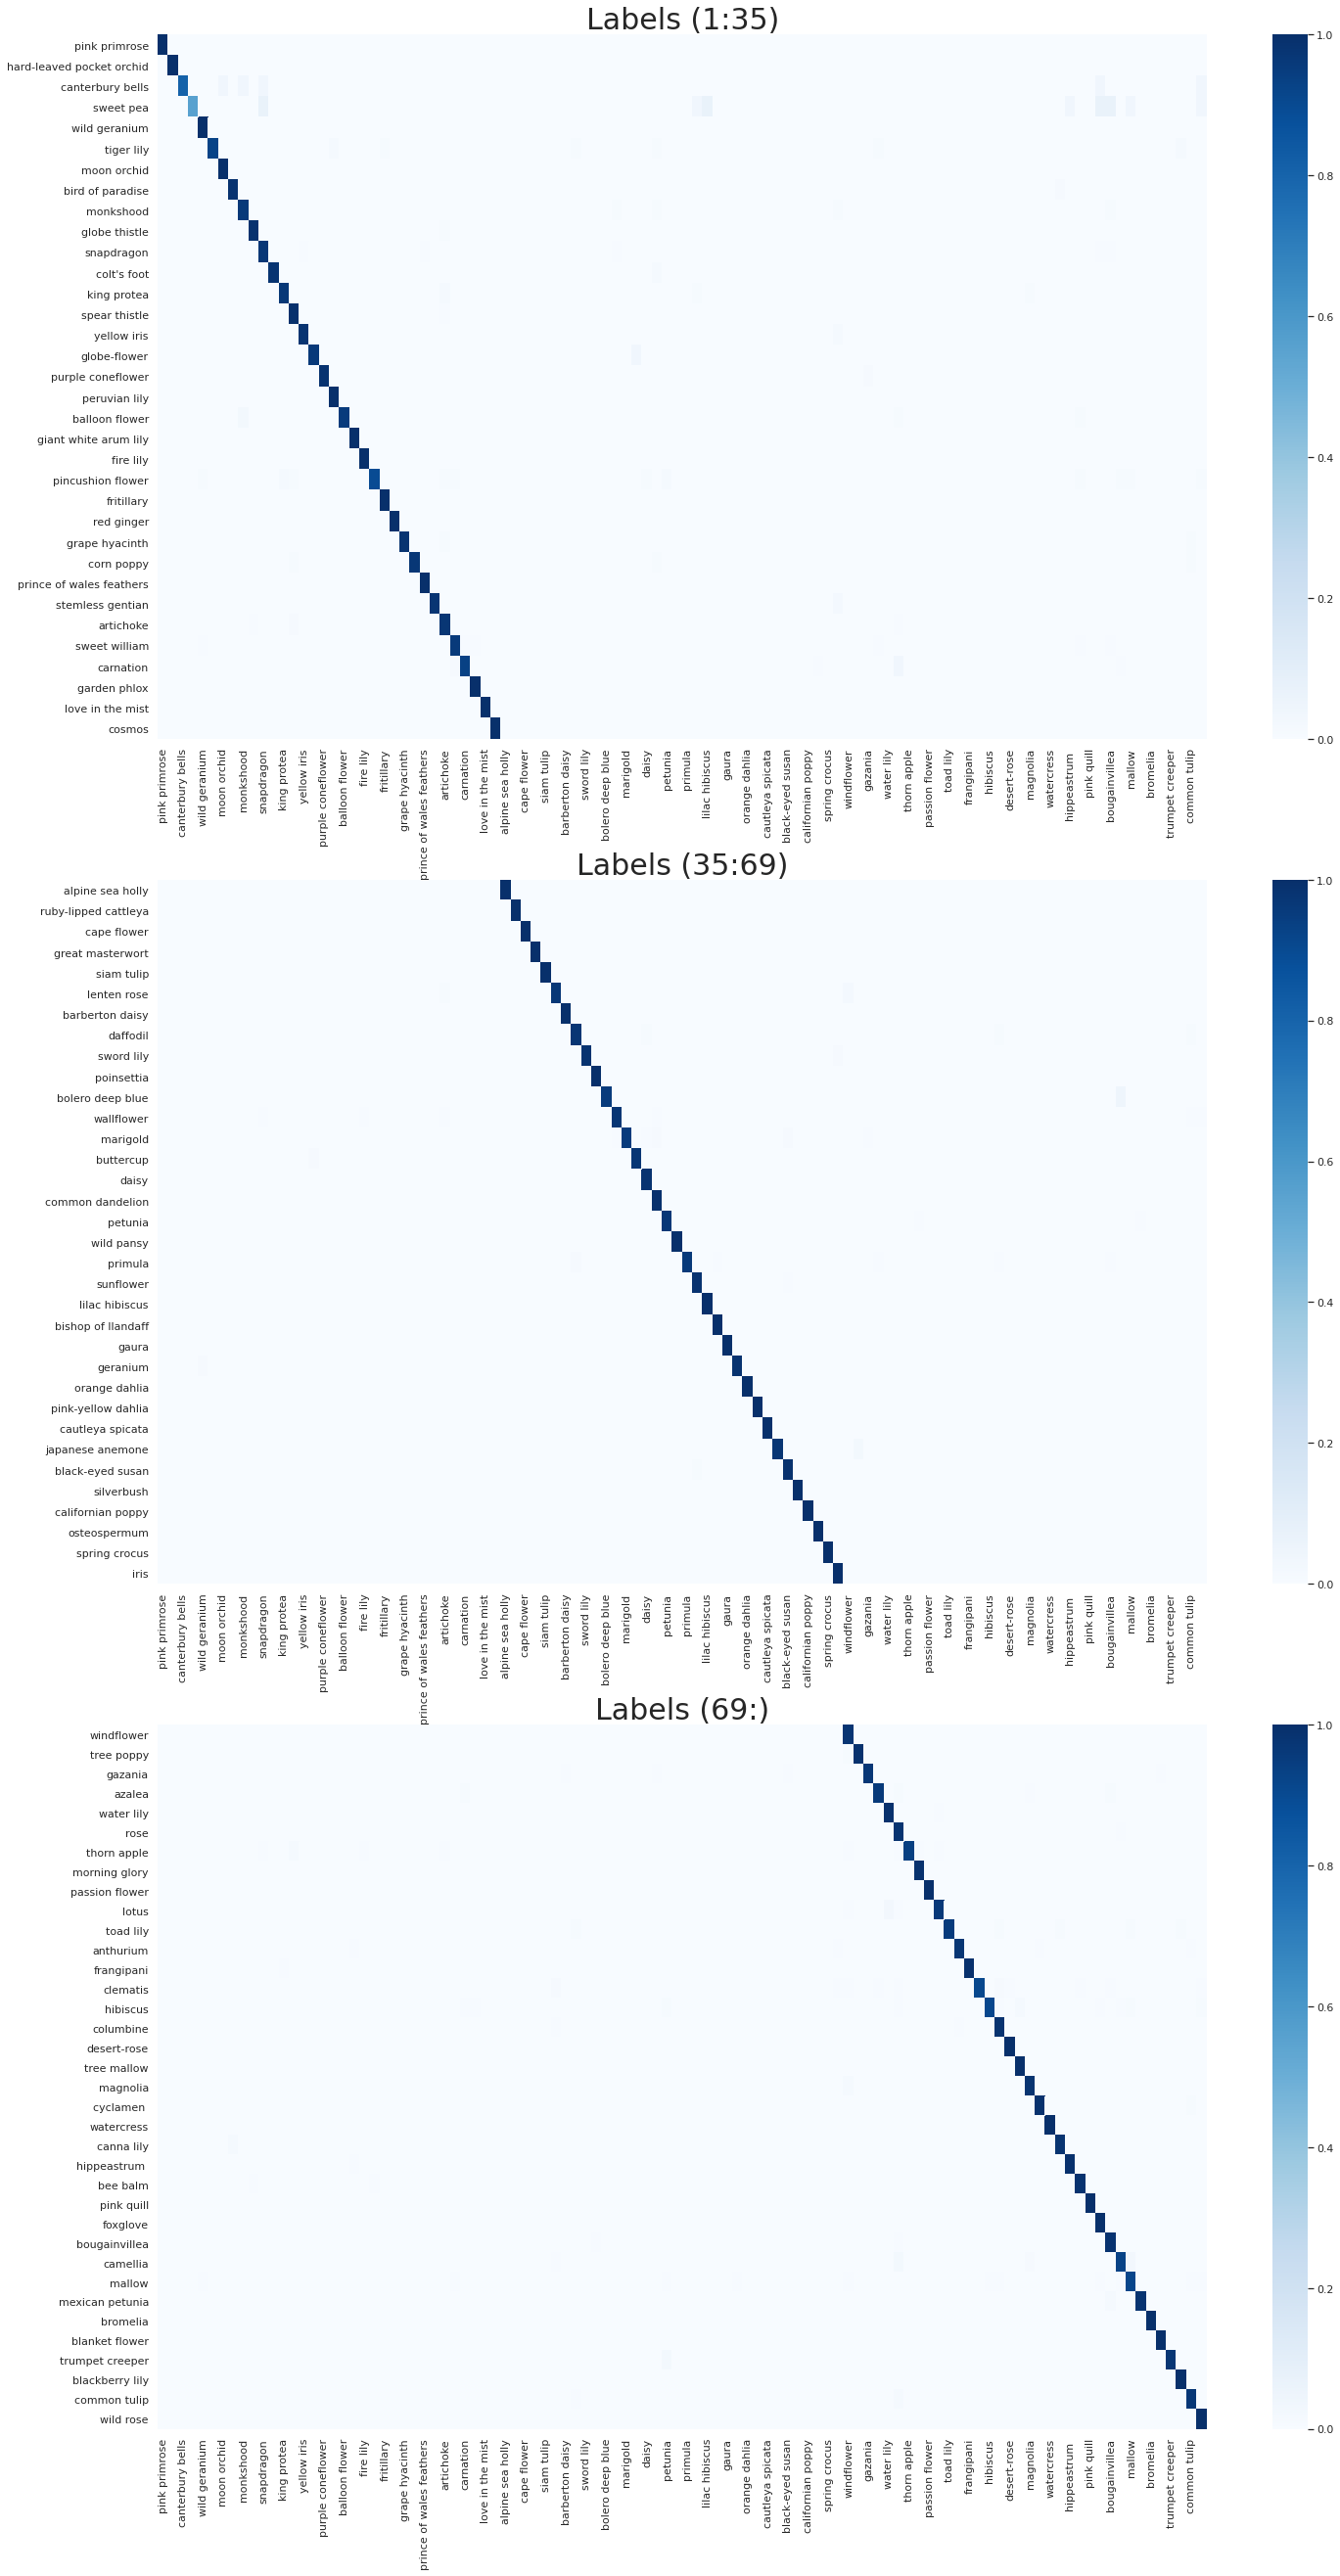

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(24, 45))

cfn_matrix = confusion_matrix(y_complete, complete_preds, labels=range(len(CLASSES)))
cfn_matrix = (cfn_matrix.T / cfn_matrix.sum(axis=1)).T

df_cm1 = pd.DataFrame(cfn_matrix[:34], index=CLASSES[:34], columns=CLASSES)
df_cm2 = pd.DataFrame(cfn_matrix[34:68], index=CLASSES[34:68], columns=CLASSES)
df_cm3 = pd.DataFrame(cfn_matrix[68:], index=CLASSES[68:], columns=CLASSES)

sns.heatmap(df_cm1, cmap="Blues", ax=ax1).set_title('Labels (1:35)', fontsize=30)
sns.heatmap(df_cm2, cmap="Blues", ax=ax2).set_title('Labels (35:69)', fontsize=30)
sns.heatmap(df_cm3, cmap="Blues", ax=ax3).set_title('Labels (69:)', fontsize=30)
plt.show()

# Visualize predictions

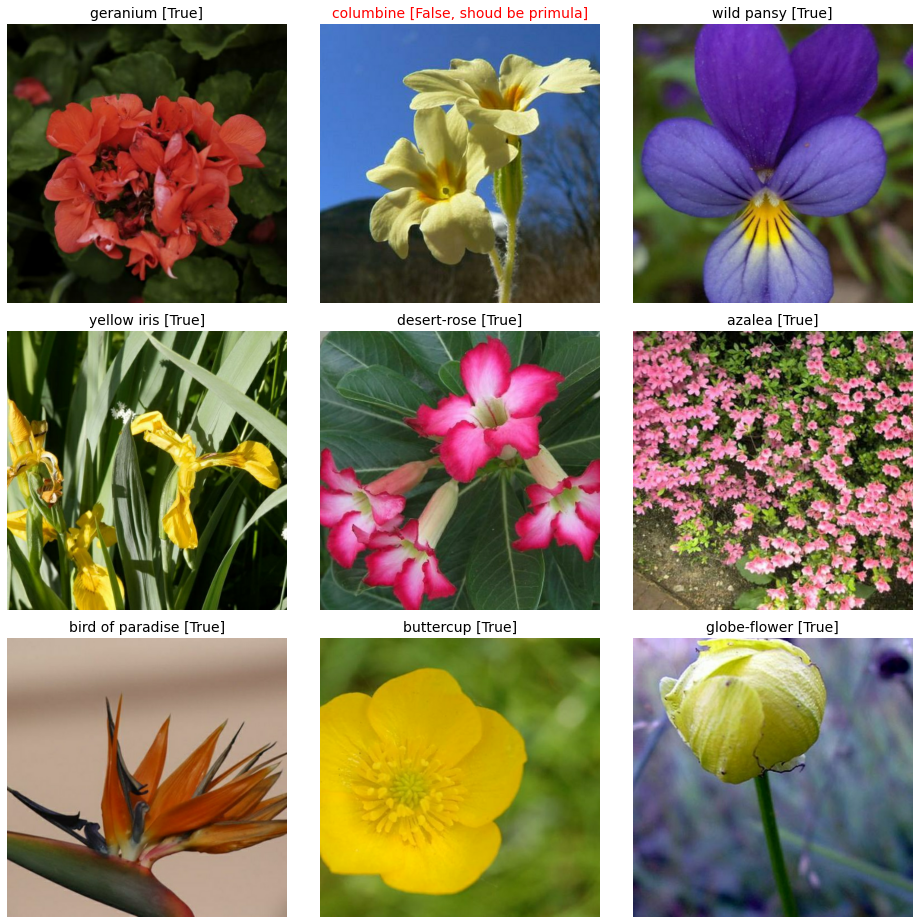

In [14]:
x_samp, y_samp = dataset_to_numpy_util(complete_dataset, 9)
samp_preds = model.predict(x_samp, batch_size=9)
display_9_images_with_predictions(x_samp, samp_preds, y_samp)

# Test set predictions

In [15]:
test_ids_ds = test_dataset.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

submission = pd.DataFrame(test_ids, columns=['id'])
submission['label'] = test_preds
submission.to_csv('submission.csv', index=False)
display(submission.head(10))

,id,label
0,252d840db,67
1,1c4736dea,28
2,c37a6f3e9,83
3,00e4f514e,103
4,59d1b6146,70
5,8d808a07b,53
6,aeb67eefb,52
7,53cfc6586,48
8,aaa580243,82
9,d907ca7c0,13
